In [5]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

from dotenv import load_dotenv
load_dotenv()
# DATASET_PATH=os.getenv("DATASET_DIRECTORY")
# DATASET_PATH="/data/RadVel"
DATASET_PATH = "/data/Hermes"
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.range_angle_resp import RangeAngleProcessor
from mmwave_radar_processing.processors.range_doppler_resp import RangeDopplerProcessor
from mmwave_radar_processing.processors.doppler_azimuth_resp import DopplerAzimuthProcessor
from mmwave_radar_processing.processors.micro_doppler_resp import MicroDopplerProcessor
from mmwave_radar_processing.processors.virtual_array_reformater import VirtualArrayReformatter
from mmwave_radar_processing.plotting.plotter_mmWave_data import PlotterMmWaveData
from mmwave_radar_processing.processors.altimeter import Altimeter
from mmwave_radar_processing.processors.velocity_estimator import VelocityEstimator
from mmwave_radar_processing.processors.range_resp import RangeProcessor
from mmwave_radar_processing.plotting.plotter_odometry_data import PlotterOdometryData
from mmwave_radar_processing.plotting.movies_odometry import MovieGeneratorOdometry

In [6]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"6843_RadVel_ods_10Hz.cfg")
cfg_manager.load_cfg(cfg_path,array_geometry="ods",array_direction="down")
cfg_manager.compute_radar_perforance(profile_idx=0)
print(f"Radar Range Resolution: {cfg_manager.range_res_m:.4f} m")

# dataset_name = "CPSL_RadVel_ods_10Hz_1"
dataset_name = "hermes_odom_test_1"
dataset_path = os.path.join(DATASET_PATH,dataset_name)
print(dataset_path)
# dataset_name = "RadSAR_2_CPSL"
# dataset_path = os.path.join(DATASET_PATH,os.pardir,"RadSAR",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="down_radar_adc", #"radar_0_adc"
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_orientation", #not implemented
    imu_full_folder="imu_data",
    vehicle_vel_folder="vehicle_vel",
    vehicle_odom_folder="vehicle_odom"
)

Radar Range Resolution: 0.0625 m
/data/Hermes/hermes_odom_test_1
found 757 radar samples
found 757 lidar samples
did not find camera samples
did not find hand tracking samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 757 vehicle velocity samples
found 757 vehicle odometry samples


In [7]:
plotter = PlotterOdometryData(config_manager=cfg_manager)
plotter.min_threshold_dB = 30

altimeter = Altimeter(
    config_manager=cfg_manager,
    min_altitude_m=25.0e-2, #15.0e-2 for 10Hz,20Hz
    zoom_search_region_m=20.0e-2,
    altitude_search_limit_m=40e-2, #20e-2
    range_bias=-0.1025 #-0.13
)

#load the ADC data reformatter
virtual_array_reformatter = VirtualArrayReformatter(config_manager=cfg_manager)

movie_generator = MovieGeneratorOdometry(
    cpsl_dataset=dataset,
    plotter=plotter,
    altimeter=altimeter,
    velocity_estimator=None,
    virtual_array_reformatter=virtual_array_reformatter,
    temp_dir_path="~/Downloads/altitude_estimation"
)


found temp dir: /home/david/Downloads/altitude_estimation
clearing temp directory /home/david/Downloads/altitude_estimation


100%|██████████| 757/757 [00:00<00:00, 1775.43it/s]


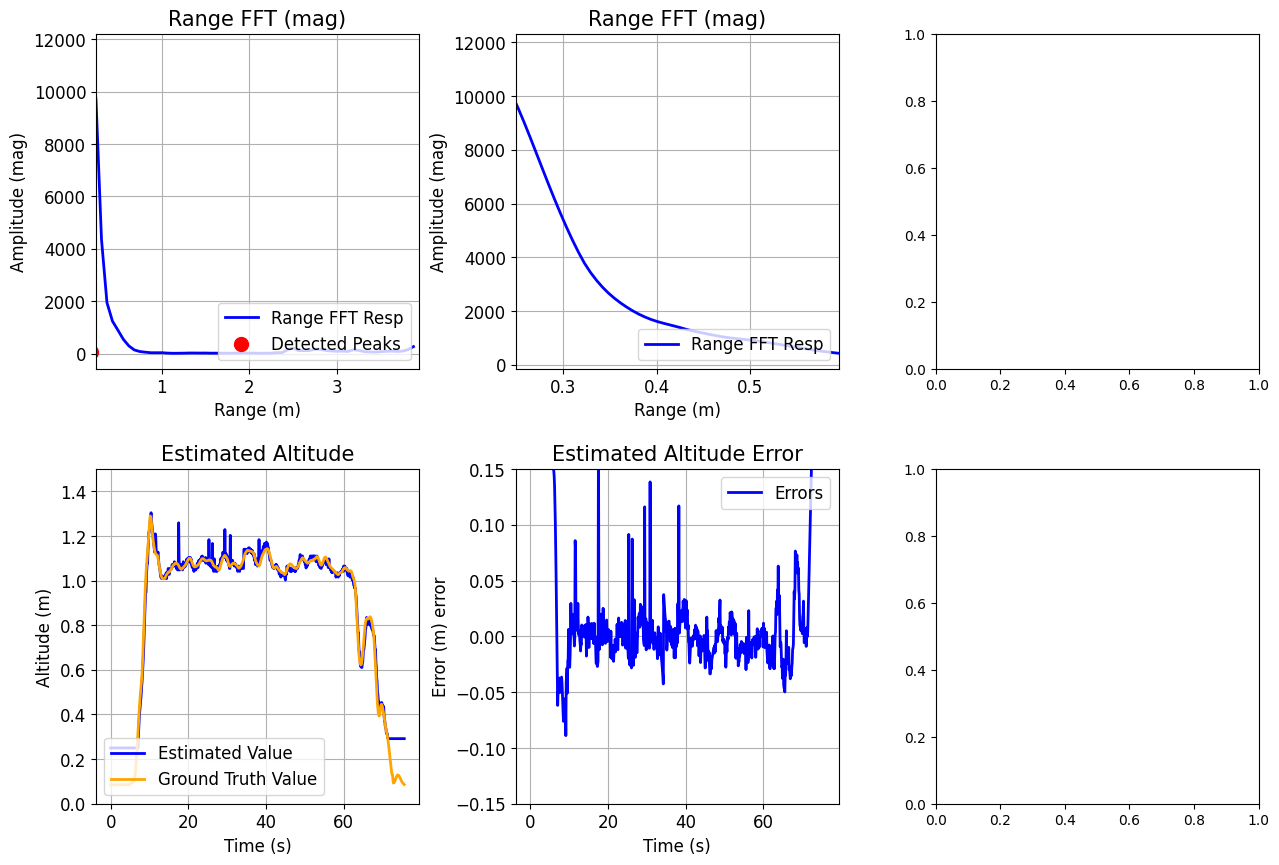

In [8]:
#for getting access to the adc cube
#good frames 10 Hz: 100 - takeoff 7- on ground 310 - moving
#good frames 5Hz diagonal: 80 
idx=dataset.num_frames#80#7#310#dataset.num_frames
altimeter.reset()
hist_test = []
hist_gt = []
#compute responses over a series of frames
#get the ADC cube

for i in tqdm(range(idx)):
    adc_cube = dataset.get_radar_data(i)
    adc_cube = virtual_array_reformatter.process(adc_cube)

    #estimate the altitude
    est_altitude = altimeter.process(adc_cube=adc_cube, precise_est_enabled=True)
    
    #save the altitude history
    vehicle_odom = dataset.get_vehicle_odom_data(idx=i)
    gt_altitude = np.average(vehicle_odom[:, 3])
    altimeter.update_history(
        estimated=np.array([est_altitude]),
        ground_truth=np.array([gt_altitude])
    )

plotter.plot_compilation(
    adc_cube=adc_cube,
    altimeter=altimeter,
    velocity_estimator=None,
    camera_view=np.empty(shape=(0)),
    show=True
)

Altitude Bias: 0.00 cm


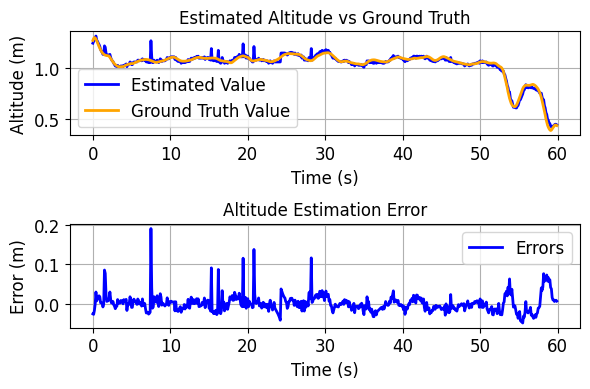

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(6, 4))

altitude_est_history = np.concatenate(altimeter.history_estimated, axis=0)
altitude_gt_history = np.concatenate(altimeter.history_gt, axis=0)

start_idx = 100
end_idx = 700
# Calculate the bias (average difference) between the altitude estimate and the ground truth
bias = np.mean(altitude_est_history[start_idx:end_idx] - altitude_gt_history[start_idx:end_idx])
print(f"Altitude Bias: {bias*100:.2f} cm")

# Adjust the altitude estimate history by subtracting the bias
altitude_est_history = altitude_est_history[start_idx:end_idx] - bias
altitude_gt_history = altitude_gt_history[start_idx:end_idx]


# First subplot: Estimated vs Ground Truth
plotter.plot_estimated_vs_ground_truth(
    estimated=altitude_est_history,
    ground_truth=altitude_gt_history,
    ax=axs[0],
    frame_rate=10,
    show=False
)
axs[0].set_title("Estimated Altitude vs Ground Truth")

# Second subplot: Error between Estimated and Ground Truth
plotter.plot_estimated_vs_ground_truth_error(
    estimated=altitude_est_history,
    ground_truth=altitude_gt_history,
    ax=axs[1],
    frame_rate=10,
    show=False
)
axs[1].set_ylabel("Error (m)",fontsize=plotter.font_size_axis_labels)
axs[1].set_title("Altitude Estimation Error")

plt.tight_layout()
plt.show()

In [10]:
import pandas as pd

# Compute the absolute error
absolute_error = np.abs(altitude_est_history - altitude_gt_history)

# Calculate the average and standard deviation
average_error = np.mean(absolute_error)
std_dev_error = np.std(absolute_error)

# Create a table to display the results
error_table = pd.DataFrame({
    "Metric": ["Average Error", "Standard Deviation"],
    "Value": [average_error, std_dev_error]
})

error_table

,Metric,Value
0,Average Error,0.014652
1,Standard Deviation,0.016838


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 1972.64it/s]


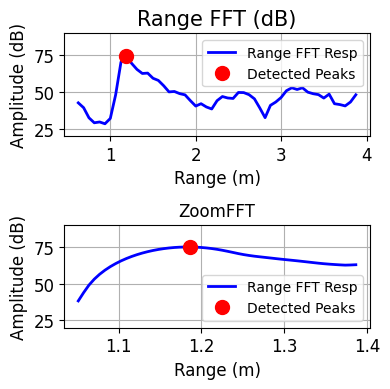

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(4, 4))
plotter.font_size_legend = 10
idx = 500
for i in tqdm(range(idx)):
    adc_cube = dataset.get_radar_data(i)
    adc_cube = virtual_array_reformatter.process(adc_cube)

    #estimate the altitude
    est_altitude = altimeter.process(adc_cube=adc_cube, precise_est_enabled=True)

#coarse FFT
coarse_fft = altimeter.coarse_fft(
    adc_cube,
    chirp_idx=0)
peak_rng_bins, peak_vals = altimeter.find_peaks(
    rng_resp_db=20*np.log10(coarse_fft),
    rng_bins=altimeter.range_bins,
    max_peaks=3
)
plotter.plot_range_resp(
    resp=coarse_fft[10:],
    rng_bins=altimeter.range_bins[10:],
    peak_rng_bins=peak_rng_bins[1:],
    peak_vals=peak_vals[1:],
    ax=axs[0],
    convert_to_dB=True,
    show=False
)

#zoom FFT
altimeter.process(adc_cube, precise_est_enabled=True)
est_altitude = altimeter.current_altitude_measured_m

range_start_m = max(0, est_altitude - altimeter.zoom_search_region_m)
range_end_m = min(plotter.config_manager.range_max_m, est_altitude + altimeter.zoom_search_region_m)  
zoom_avg, zoom_range_bins = altimeter.zoom_fft(
    adc_cube=adc_cube,
    range_start_m=range_start_m,
    range_stop_m=range_end_m,
    chirp_idx=0
)
axs[0].set_ylim([20,90])
axs[0].legend(loc='upper right')


peak_rng_bins, peak_vals = altimeter.find_peaks(
    rng_resp_db=20*np.log10(zoom_avg),
    rng_bins=zoom_range_bins,
    max_peaks=1
)
plotter.plot_range_resp(
    resp=zoom_avg[10:],
    rng_bins=zoom_range_bins[10:],
    peak_rng_bins=peak_rng_bins,
    peak_vals=peak_vals,
    ax=axs[1],
    convert_to_dB=True,
    show=False
)
axs[1].set_title("ZoomFFT")
axs[1].set_ylim([20,90])

plt.tight_layout()
plt.show()

100%|██████████| 657/657 [00:33<00:00, 19.79it/s]


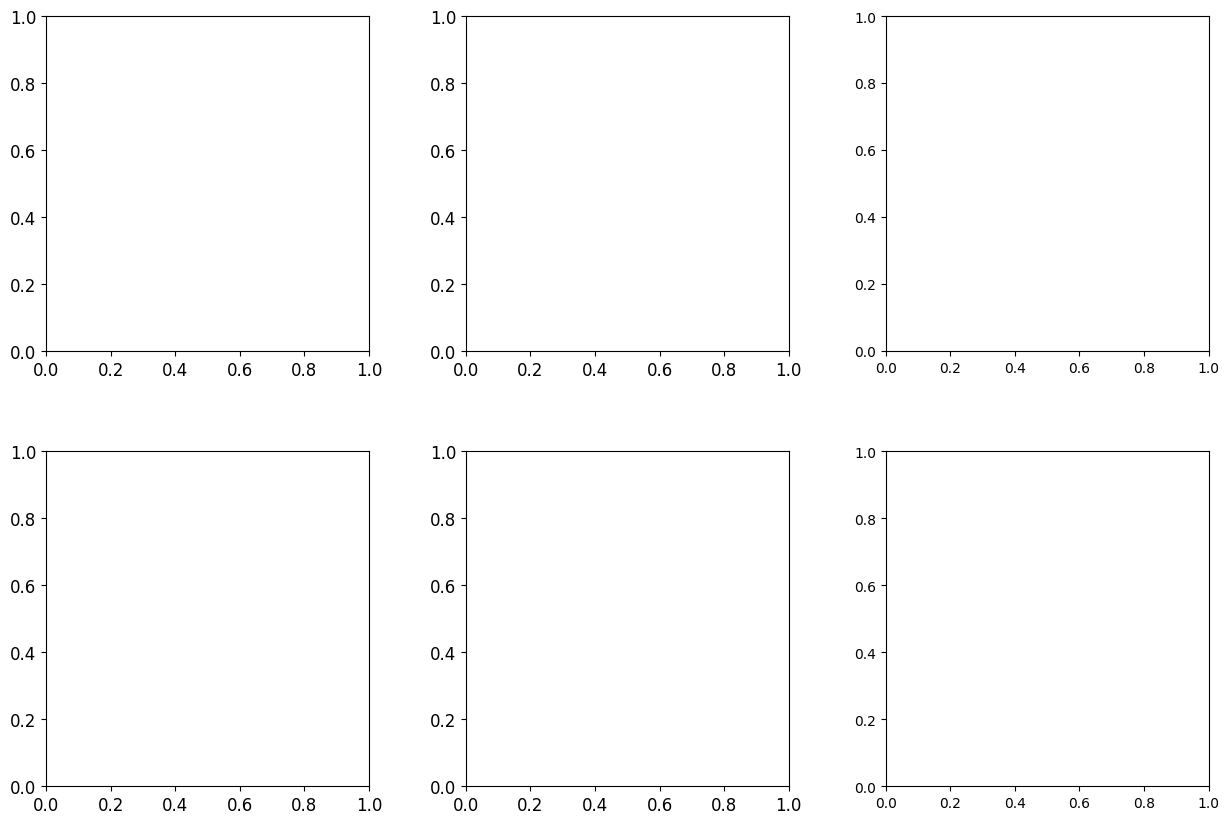

In [12]:
#generate the movie
movie_generator.initialize_figure(nrows=2,ncols=3,figsize=(15,10))
altimeter.reset()

movie_generator.generate_movie_frames(
    cmap="viridis",
    convert_to_dB=True,
    start_idx=100,
)

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}_altitude_est.mp4".format(dataset_name),fps=fps)